In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_curve, auc, recall_score, precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
WORK_DIR = '/content/drive/My Drive/Dataset/'

CLASSES = [
    'normal',
    'glaucoma',
    'diabetic_retinopathy',
    'cataract'
]

IMG = 224

IMAGE_SIZE = [224, 224]
DIM = (IMG, IMG)

model_acc = {}
model_val_acc = {}

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(
    rescale=1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT,
    fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=4237, shuffle=True)


Found 4237 images belonging to 4 classes.


(4237, 224, 224, 3) (4237, 4)


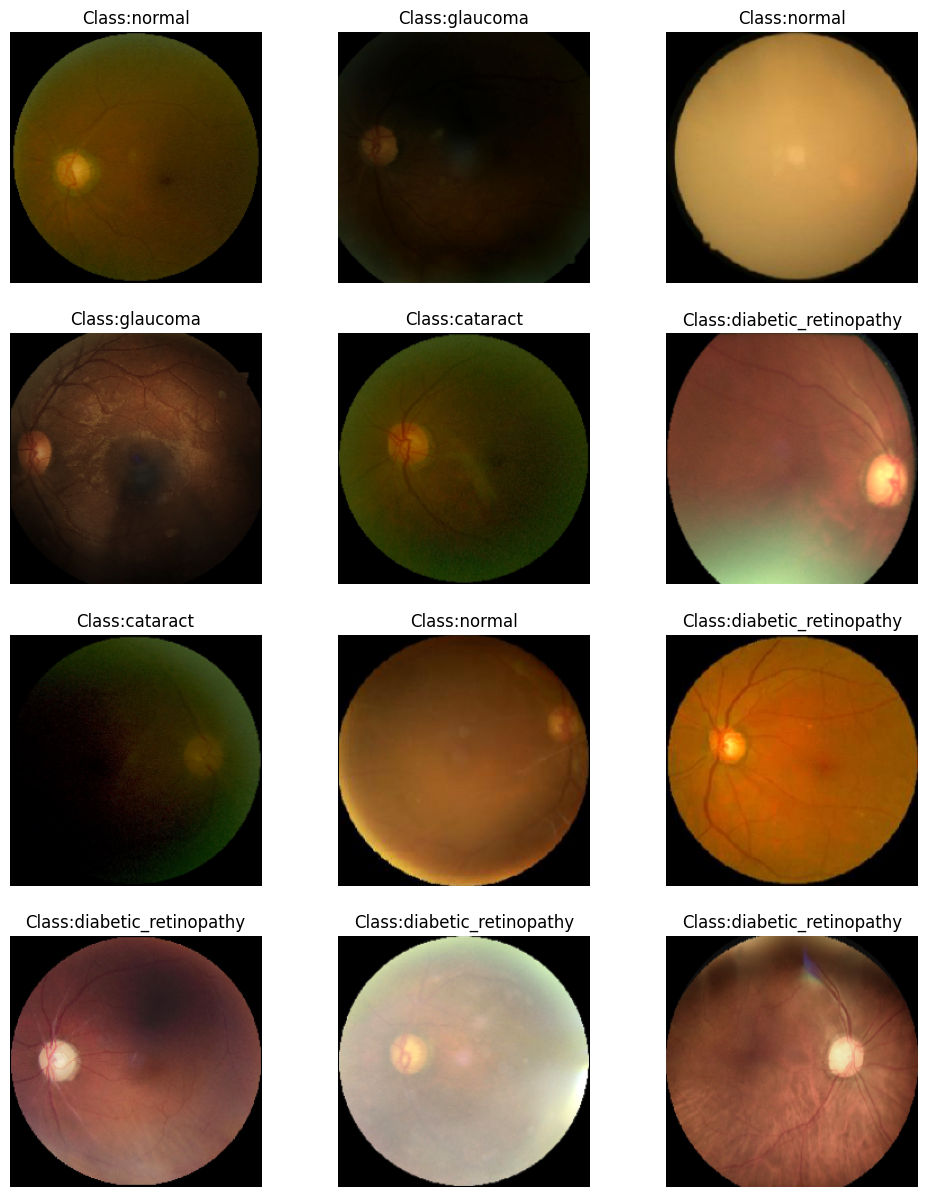

In [ ]:
# get image lables
labels = dict(zip([0, 1, 2, 3], CLASSES))
# get a batch of images
train_data, train_labels = train_data_gen.next()

# display a grid of 9 images
plt.figure(figsize=(12, 15))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    idx = randint(0, 4237)
    plt.imshow(train_data[idx])
    plt.axis("off")
    plt.title("Class:{}".format(labels[np.argmax(train_labels[idx])]))

print(train_data.shape, train_labels.shape)

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [ ]:
# Define the number of classes
NUM_CLASSES = 4

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
 layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
EPOCHS = 50
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)


Epoch 1/50
 50/106 [=============>................] - ETA: 23:00 - loss: 1.4404 - accuracy: 0.2644